In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e12/sample_submission.csv
/kaggle/input/playground-series-s3e12/train.csv
/kaggle/input/playground-series-s3e12/test.csv
/kaggle/input/kidney-stone-prediction-based-on-urine-analysis/kindey stone urine analysis.csv


In [2]:
import warnings
warnings.filterwarnings('ignore', message=".*The 'nopython' keyword.*");
warnings.filterwarnings(action='ignore', category=DeprecationWarning);
warnings.filterwarnings(action='once')

In [3]:
# Ploting libraries
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import HTML
sns.set_style("darkgrid")

# Ploting high-dimesional data into 2D libraries
import umap;
from sklearn.manifold import TSNE;

# To deal with outliers
from scipy.stats.mstats import winsorize

# For data preprocessing
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# For modelling
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier

# For metrics and hyperparameter tuning
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from scipy.stats import uniform, loguniform, randint

/opt/conda/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/lib/python3.10/site-packages/umap/umap_.py:660: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 

# 1. Hello World!
<hr>

Welcome to this Kaggle notebook on kidney stones, a condition that affects millions of people worldwide.
Did you know that kidney stones are common with an estimated prevalence of **12%** in men and **6%** in women? These small mineral deposits can cause excruciating pain and significantly impact everyday life. Kidney stones account for over **500,000** emergency room visits in the United States alone! 

<center>
    <img src="https://reverehealth.com/static/8d9fa666d2633b9771026e683d02b45e/c1c8d/iStock-493449063.webp"  width="600" height="300">
</center>

By exploring this dataset, we not only aim to understand the fundamentals of data science problem but also aim to deepen our understanding on kidney stones. This will hhelp us connect well with the problem and might empower us to develop better prevention strategies in future. The intention is spread the knowledge while learning. Before we continue, let's drink a glass of water and prevent the risk of kidney stones. 🫗

The 💡 icon is used throughout the notebook for facts/sciences revealing domain knowledge about kidney stones. Feel free to skip those if needed. 

<hr>

# 2. Loading Data

In [4]:
df = pd.read_csv("../input/playground-series-s3e12/train.csv")
test_df = pd.read_csv("../input/playground-series-s3e12/test.csv")
sub_df = pd.read_csv("../input/playground-series-s3e12/sample_submission.csv")

In [5]:
display(df.head())
print(df.shape)

,id,gravity,ph,osmo,cond,urea,calc,target
0,0,1.013,6.19,443,14.8,124,1.45,0
1,1,1.025,5.40,703,23.6,394,4.18,0
2,2,1.009,6.13,371,24.5,159,9.04,0
3,3,1.021,4.91,442,20.8,398,6.63,1
4,4,1.021,5.53,874,17.8,385,2.21,1


(414, 8)


## 2.1 Data Charactersitics:
We shall now look at the number of missing values, unique values, duplicate value, datatype, min, max and few values.

Inspired by @datamanyo

In [6]:
def get_data_char(df):
    data_columns = df.columns
    data_char_df = pd.DataFrame(df.dtypes, columns = ["d_type"])
    data_char_df["#_missing"] = df.isna().sum()
    data_char_df["%_missing"] = df.isna().sum() * 100 / df.shape[0]
    data_char_df["#_unique"] = df.nunique()
    data_char_df["%_unique"] = df.nunique() * 100 / df.shape[0]
    data_char_df["most_frequent"] = df.mode().loc[0]
    
    def get_stats_stats(df):
        return df.aggregate([min, max, "mean", "median", "std"]).T
    
    data_char_df = pd.concat([data_char_df,get_stats_stats(df), df.loc[:2,].T], axis = 1)    
    
    return data_char_df
display(get_data_char(df.iloc[:,1:]).style.background_gradient(subset = ["%_unique", "std", "median", "mean", "max", "min", "%_missing"], cmap = "Oranges"))

,d_type,#_missing,%_missing,#_unique,%_unique,most_frequent,min,max,mean,median,std,0,1,2
gravity,float64,0,0.000000,28,6.763285,1.021000,1.005000,1.040000,1.017894,1.018000,0.006675,1.013000,1.025000,1.009000
ph,float64,0,0.000000,71,17.149758,5.530000,4.760000,7.940000,5.955459,5.740000,0.642260,6.190000,5.400000,6.130000
osmo,int64,0,0.000000,80,19.323671,577.000000,187.000000,1236.000000,651.545894,679.500000,234.676567,443.000000,703.000000,371.000000
cond,float64,0,0.000000,65,15.700483,29.000000,5.100000,38.000000,21.437923,22.200000,7.514750,14.800000,23.600000,24.500000
urea,int64,0,0.000000,73,17.632850,159.000000,10.000000,620.000000,278.657005,277.000000,136.442249,124.000000,394.000000,159.000000
calc,float64,0,0.000000,85,20.531401,4.490000,0.170000,14.340000,4.114638,3.130000,3.217641,1.450000,4.180000,9.040000
target,int64,0,0.000000,2,0.483092,0.000000,0.000000,1.000000,0.444444,0.000000,0.497505,0.000000,0.000000,0.000000


#### Insights:
1. We have 6 independent variable, all of which are continous in nature, one identification variable (id) and one binary target variable.
2. The dataset has no missing values.
3. Most unique column is calc with just 20% unique data
3. The target varible has a mean < 0.5 and median of 0, indicating that the number of positive class (+1) examples are less than that of number of negative class examples (0)
4. The scales of the features vary a lot, the mean and std of gravity and osmo are on different scales (ones, hundreds). Scaling/Normalizing them is important.
5. The maximum and minimum values in the osmo, urea features vary a lot. Outliers may be present.
                                     

## 💡 Understanding Kidney Stones:
<hr>
Kidney stones are hard mineral and crystalline (informally called, stone) deposits that form in the kidneys or other parts of the urinary tract. They cause severe pain and discomfort when they obstruct the flow of urine.

**Symptoms**: Severe pain in the back, side, or lower abdomen. Painful urination. Blood in the urine.

##### These stones typically form when the concentration of certain substances in the urine, such as **calcium, oxalate, uric acid, or cystine**, becomes too high, which eventually leads to four different kinds of stones. 

It makes perfect sense that we have **calc and urea features** in our dataset that measures their concentration.
<hr>

In [7]:
columns = df.columns[1:-1]
label = df.columns[-1]
print(columns)

df["target"] = df["target"].astype("category")

Index(['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc'], dtype='object')


# 3. EDA

In this section, we explore the traits and relationships among the features. We also draw a comparitive distribution among the train and test dataset.
We explore univarite, bivariate and finally multivariate relationships.

## 3.1 Univariate

<Axes: xlabel='target', ylabel='count'>

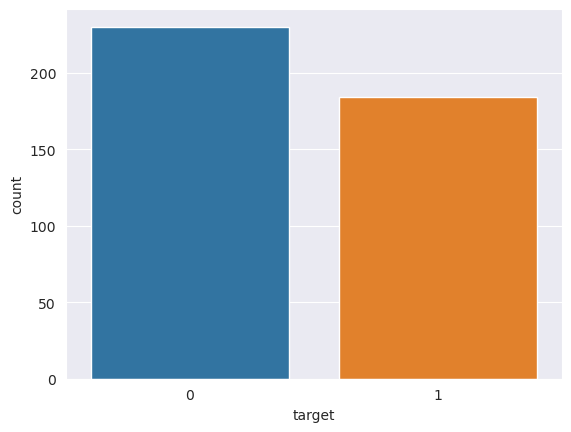

In [8]:
sns.countplot(x = df["target"])

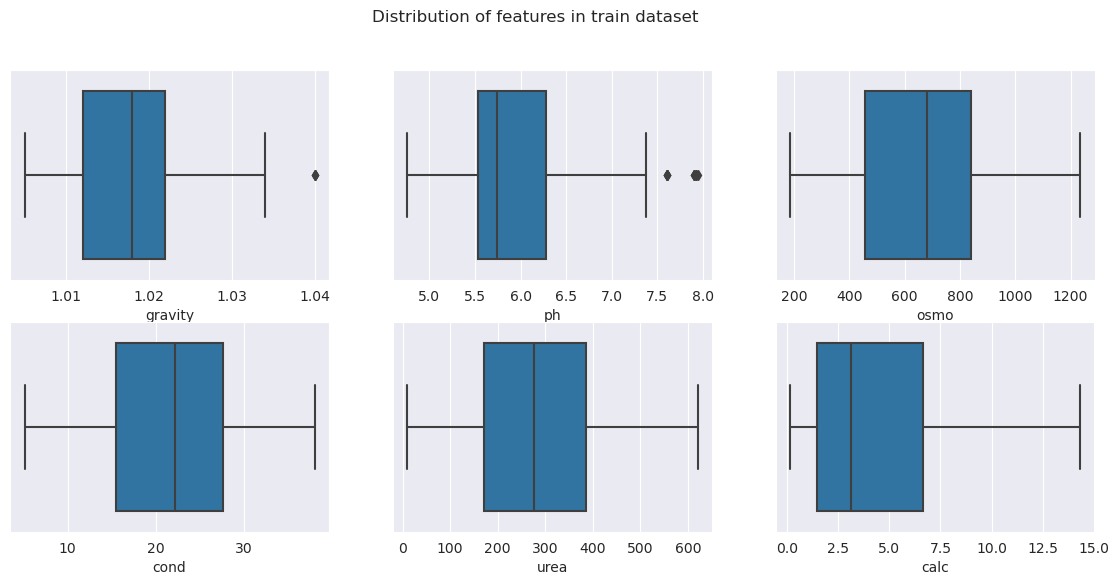

In [9]:
fig, axes = plt.subplots(2, 3, figsize = (14,6))
fig.suptitle('Distribution of features in train dataset')
for i in range(6):
    sns.boxplot(data = df, x = columns[i], ax = axes[i//3, i%3])
plt.show()

#### Insights:
There are outliers in the ph and gravity features. We will handle them in the data processing sections.

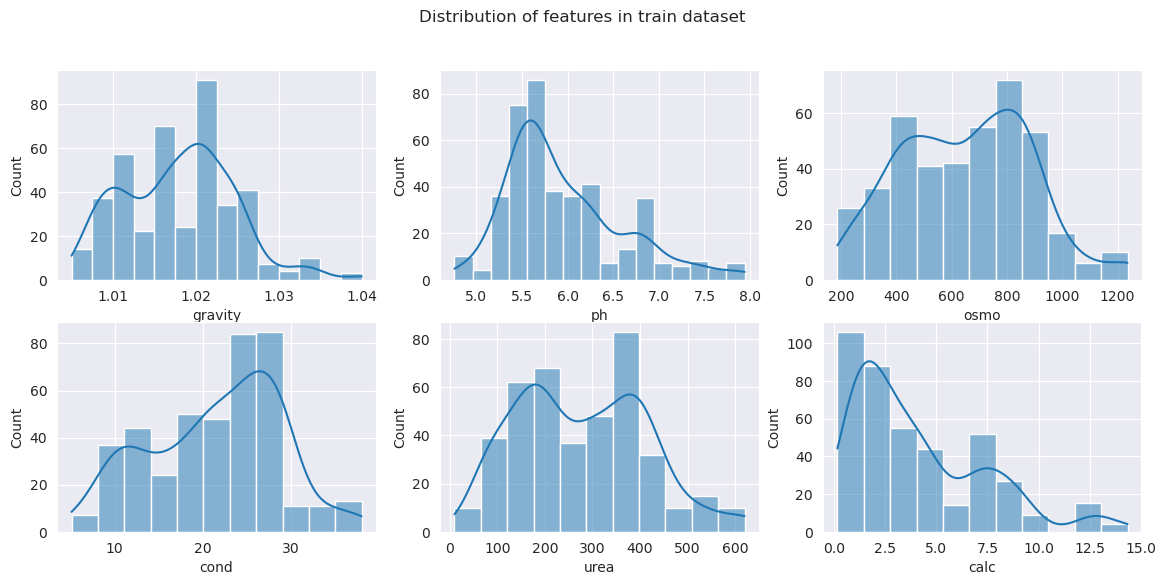

In [10]:
fig, axes = plt.subplots(2, 3, figsize = (14,6))
fig.suptitle('Distribution of features in train dataset')
for i in range(6):
    sns.histplot(data = df, x = columns[i], ax = axes[i//3, i%3], kde = True)
plt.show()

#### Insight:
All the features have a multi-modal distribution

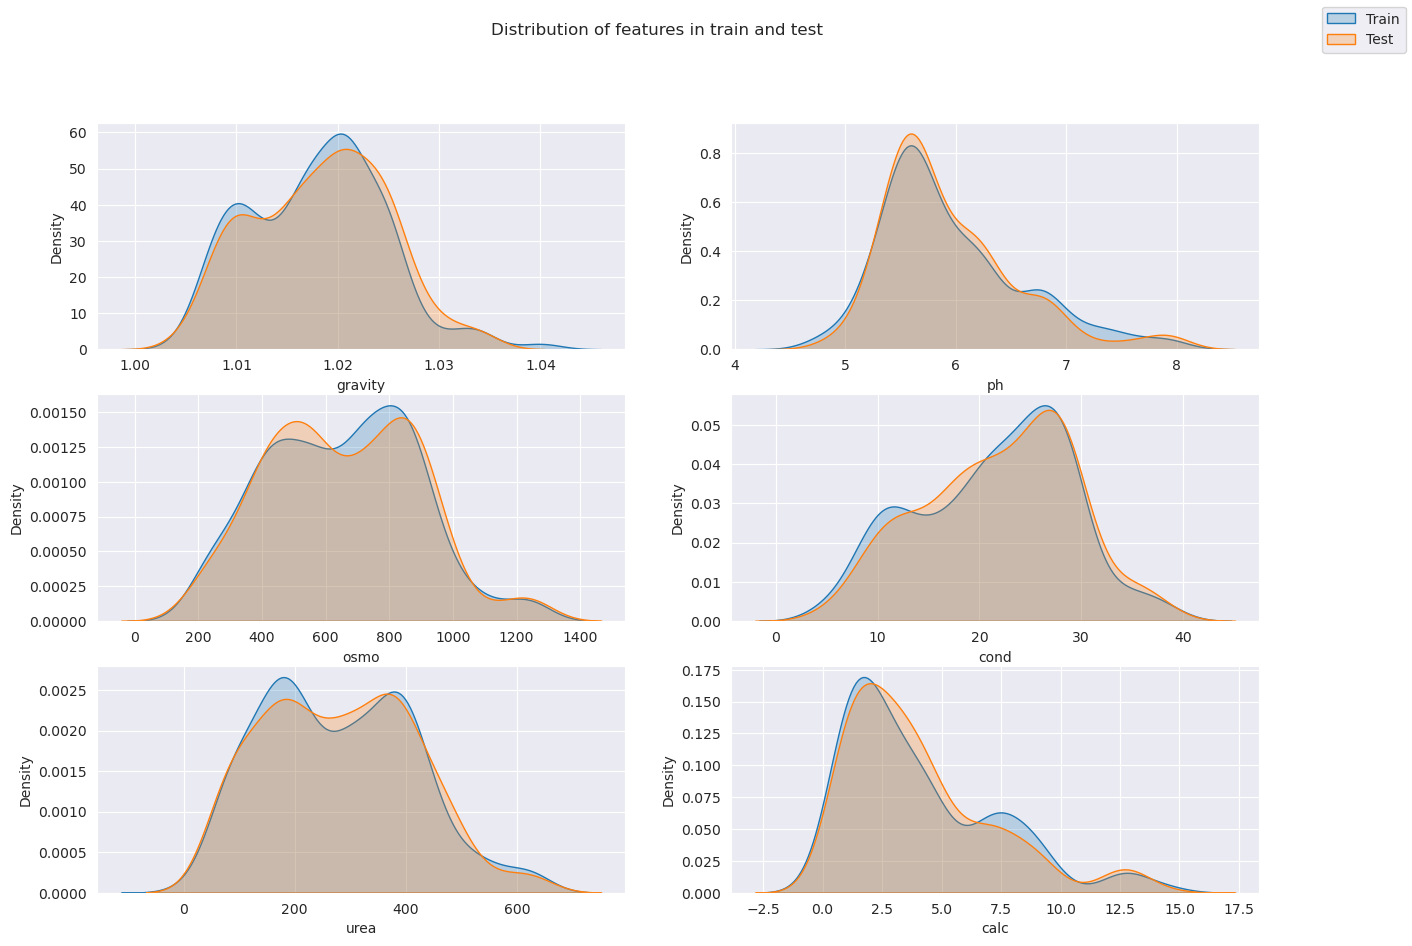

In [11]:
fig, axes = plt.subplots(3, 2, figsize = (15,10))
fig.suptitle('Distribution of features in train and test ')
for i in range(6):
    sns.kdeplot(df.iloc[:,i+1], ax = axes[i//2, i%2], fill = True)
    sns.kdeplot(test_df.iloc[:,i+1], ax = axes[i//2, i%2], fill = True)
fig.legend(labels=['Train','Test'])
plt.show()

#### Insights:
The distribution in the train and test dataset is nearly the same. That helps!

### 3.2 Bivariate

### 💡 Understanding the role of urea, calcium and conductivity in urine:
<hr>
When a person suffers from excruciating pain and if the doctor suspects that they may have kidney stones, then one of the diagnosis performed is urine analysis.
In this, patient's urine is inspected for "too many stone formation minerals" and "too few stone prevention substances". Calcium and uric acid are some of the stone formation minerals.


1. **Calcium:** Calcium based stones compose the majority ratio of stone. Nearly 80-90%. Therefore higher the concentration of calcium ions in the urine, higher is the chances of formation of kidney stone. 
2. **Urea:** Urea is one of toxic by products, which is originated when liver metabolizes protein resulting in ammonia which is further converted to urea. Urea, being one of the major solutes in urine,can help in identifying if a urine is concentrated. Higher the urea concentration, higher the osmolarity. (more on osmolarity below)
3. **Conductivity:**  Its a measure of the ability of solution to conduct an electrical current. It indicates the presence of free ions. Urine consist of many kinds of ions such as $Ca^{2+}, Mg^{2+}, Na^+, K^+, PO_4^3, C_2O_4^{2-}$ (oxalate). Higher conductivity means higher presence of ions, which might not necessarilly mean, that it has higher concentraion of stone formation ions like $Ca^{2+},PO_4^3, C_2O_4^{2-}$. So conductivity might not be a direct factor to presence of kidney stone
<hr>

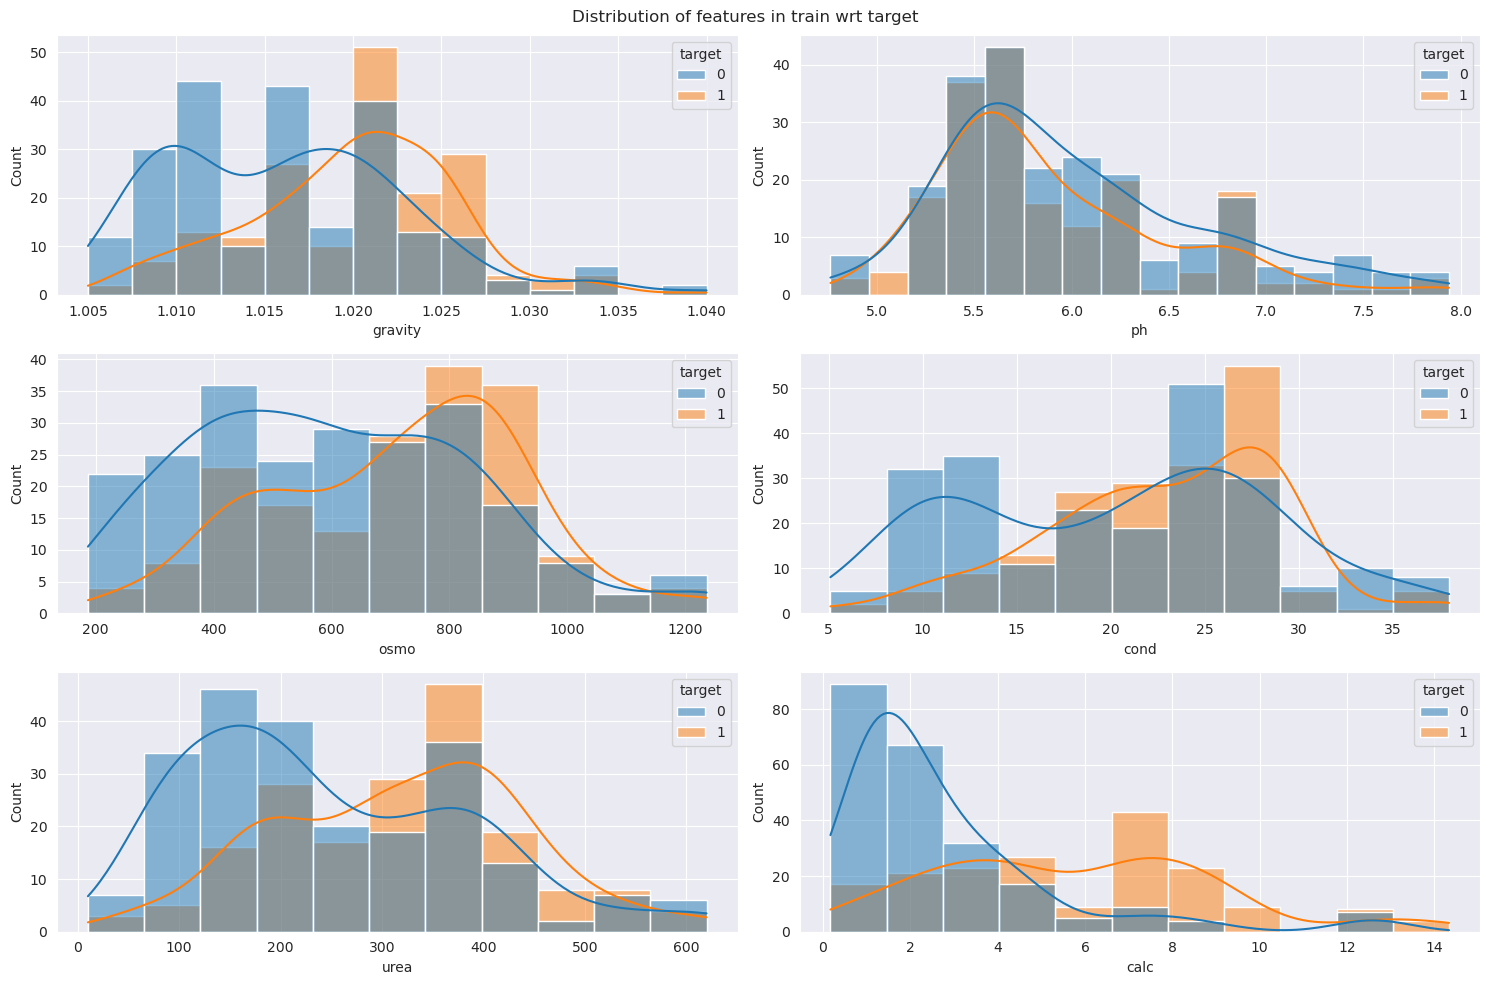

In [12]:
fig, axes = plt.subplots(3, 2, figsize = (15,10))
fig.suptitle('Distribution of features in train wrt target')
for i in range(6):
    sns.histplot(data = df, x = columns[i], hue = "target", ax = axes[i//2, i%2], kde = True)
fig.tight_layout()
plt.show()


#### Insight:
It appears, calc might also have some outliers. we will deal this later.

### 💡 Understanding role of ph, gravity and osmolarity in urine:
**pH:** Different types of kidney stones can form under varying pH conditions. 
For example, urine with lower pH levels is more conducive to the formation of uric acid stones and promotes calcium oxalate stones which are majority of all stones, while urine with higher pH levels can increase the risk of struvite stones. Therefore, on interpreting the graph for ph vs target, there are two bumps, one around 5.5 and another around 6.5.

**Gravity:** Gravity measures the density of urine wrt water. Presence of electrolytes, metabolites, and waste products affects the density of the urine. When the concentration of these substances is high, the urine becomes more concentrated and the specific gravity increases. Values above normal range may suggest concentrated urine, which might mean dehydration, reduced fluid intake, which might promote stone formation environment. Therefore, on interpreting the graph for gravity vs target, higher gravity attributes more towards positive examples.

**Osmolarity**: Osmolarity is the concetration of the solutes in a solution and I think you might have guessed it by now. In concentrated urines, water content is low which leads to higher osmolarity, hihger gravity and higher conductivity, promoting crystallization and forming stones.

Note: None of the above 6 features are used as a stand-alone diagnosis for kidney stone. All are used in conjunction with other testd results to aid in the diagnosis.

### Put on your thinking caps! 🎓

By understanding the role of features above, we get enough domain knowledge to state:
1. Gravity and osmolarity go hand in hand and thus should have extreme positive correlation.
2. osmolarity and conductivity also go parallely and should have positive correlation.
2. Urea and calcium should share a positive correlationship with gravity and osmolarity.
3. Acidic ph values should have positive relationship with urea and calcium
4. As higher conductivity might result from other ions, calc might have weak/neither relationship


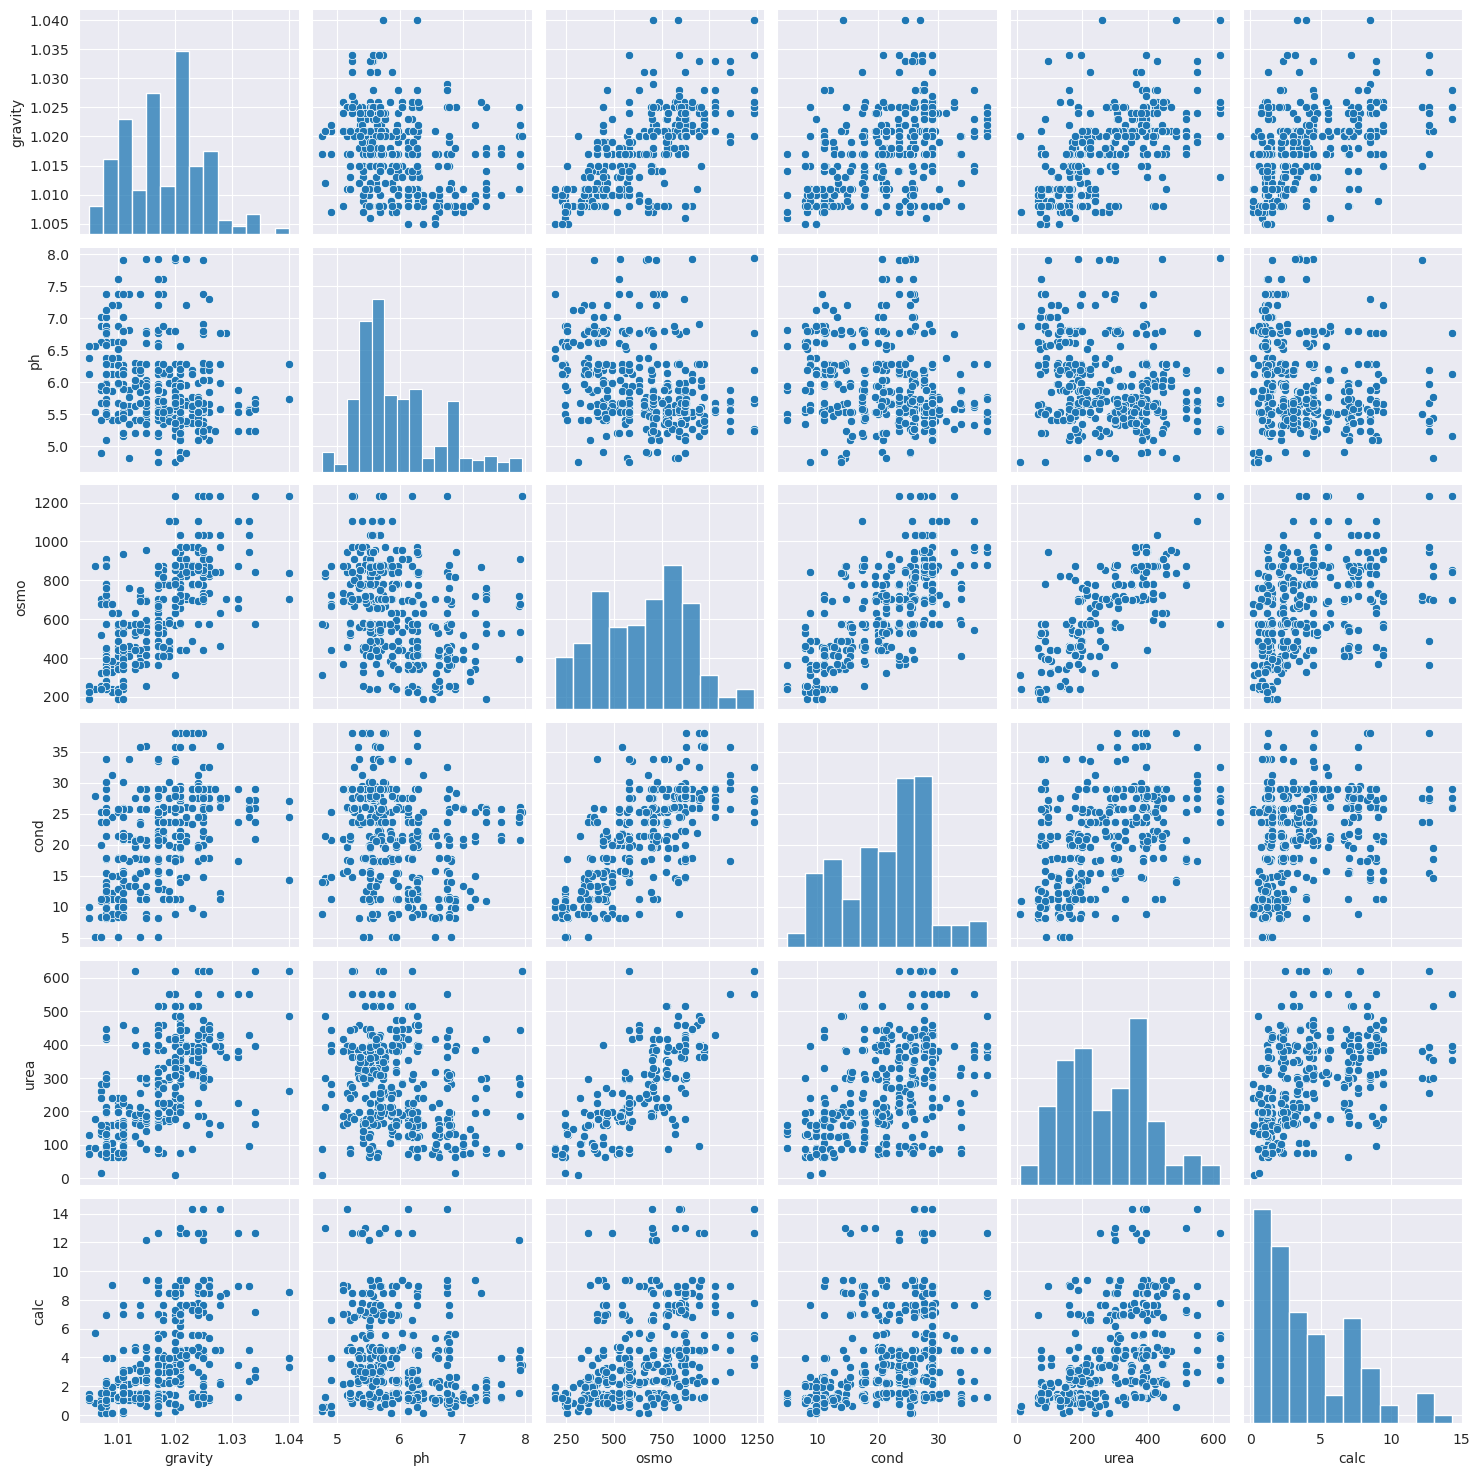

In [13]:
sns.pairplot(df[columns])

### 3.3 Multivariate 


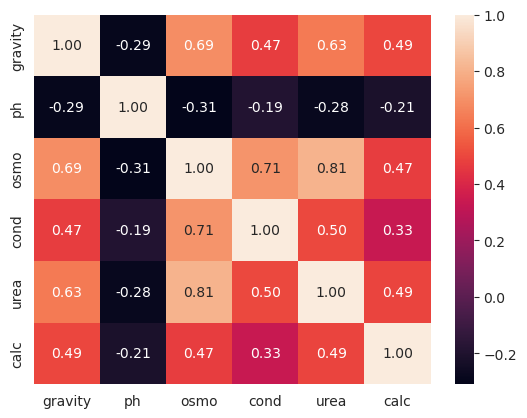

In [14]:
sns.heatmap(df[columns].corr(), annot = True, fmt = ".2f");

#### The above plot confirms are thoughts, excepts the 4th one :/

> 1. Gravity and osmolarity go hand in hand and thus should have extreme positive correlation.
> 2. osmolarity and conductivity also go parallely and should have positive correlation.
> 2. Urea and calcium should share a positive correlationship with gravity and osmolarity.
> 3. Acidic ph values should have positive relationship with urea and calcium []
> 4. As higher conductivity might result from other ions, calc might have weak/neither relationship

### 3.4 High Dimensional visualization - UMAP/T-SNE

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:917: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  val in data
/opt/conda/lib/python3.10/site-packages/pandas/core/arrays/categorical.py:197: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return getattr(np.array(self), opname)(np.array(other))
/opt/conda/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:273: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  res_values = op(lvalues, rvalues)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:917: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  val in data
/opt/conda/lib/python3.10/site-packages/pandas/core/arrays/categorical.py:197: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return getattr(np.array(self), opname)(np.array(other))
/op

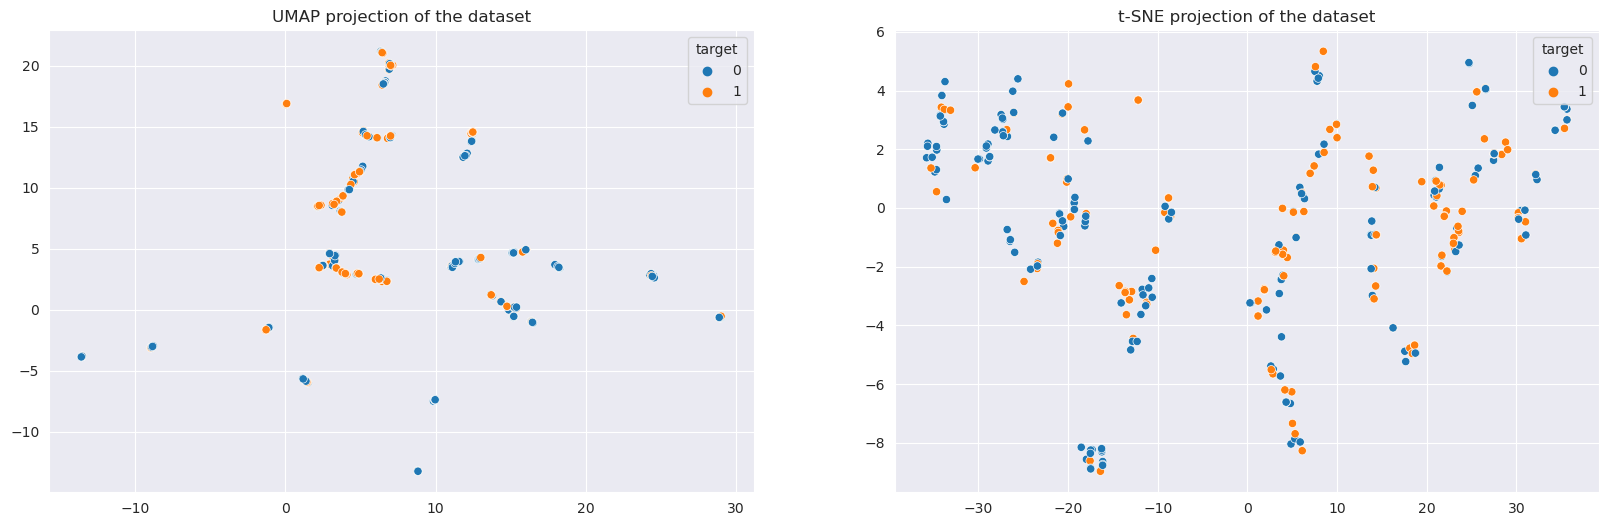

In [15]:
umap_data = umap.UMAP(n_components=2, random_state=42).fit_transform(df[columns])
tsne_data = TSNE(n_components=2, init='pca', random_state=42).fit_transform(df[columns])

fig, axes = plt.subplots(1, 2, figsize=(20,6), squeeze=False)

sns.scatterplot(umap_data, x=umap_data[:, 0], y=umap_data[:, 1], hue=df["target"], ax=axes[0,0])
axes[0,0].set_title("UMAP projection of the dataset")
sns.scatterplot(tsne_data, x=tsne_data[:, 0], y=tsne_data[:, 1], hue=df["target"], ax=axes[0,1])
axes[0,1].set_title("t-SNE projection of the dataset")

plt.show()

#### Insight:
The projection is difficult to interpret. But, there are a few sections in the above projections where the target variable is separable. 

# 4. Data Preprocessing

In this section, we deal with missing, duplicated, and outlier values. 
We would also scale the data, perform feature engineering and create X_train, X_test, y_train, y_test.

As we looked earlier, our dataset doesn't have missing and duplicated values. So we focus on dealing with outliers.

In [16]:
df_original = df.copy(deep = True)
df = df_original

X = df[columns].copy(deep = True)
y = df["target"].copy(deep = True)

### 4.1 Outlier - Using Winsorization - Shifting the outlier to 5th or 95th percentile value:

We identified in section 3.1, 3.3 that gravity ph and calc contain outlier.

In [17]:
outlier_columns = ["gravity", "ph", "calc"]
for col in outlier_columns:
    X.loc[:,col] = winsorize(X[col], (0.05, 0.05))

##### Plot them again and check:

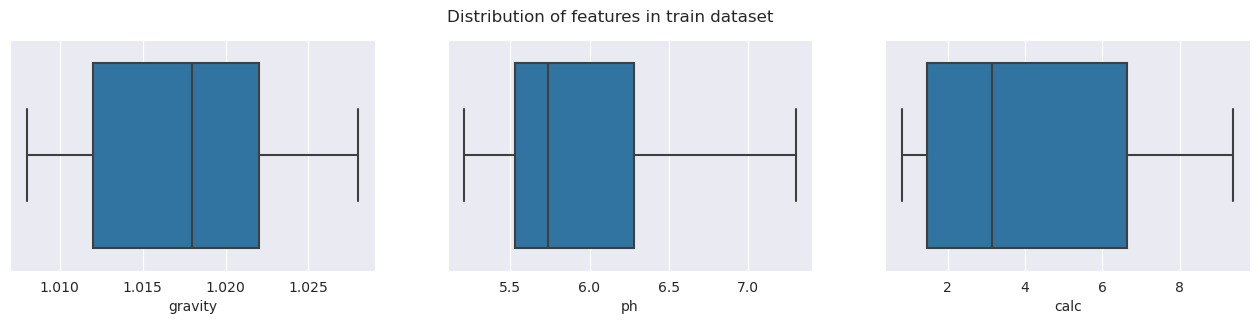

In [18]:
fig, axes = plt.subplots(1, 3, figsize = (16,3))
fig.suptitle('Distribution of features in train dataset')
for start, i in enumerate(outlier_columns):
    sns.boxplot(data = X, x = i, ax = axes[start%3])
plt.show()

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

### 4.2 Feature scaling

In [20]:
scaler = StandardScaler()
# poly = PolynomialFeatures()

X_train = scaler.fit_transform(X_train)
# X_train = poly.fit_transform(X_train)

X_test = scaler.transform(X_test)
# X_test = poly.transform(X_test)

print(X_train.shape, X_test.shape)

(351, 6) (63, 6)


# 5. Modelling

In [21]:
def generate_models(name, estimator_obj, hyperparams):
    return {
        "name" : name,
        "estimator" : estimator_obj,
        "hyperparameters" : hyperparams
    }

models = [
    generate_models("DummyClassifier", DummyClassifier(), 
                    {'strategy': ['most_frequent',"stratified"]}),
    generate_models("LogisticRegression",LogisticRegression(random_state=42),
                    {"C" : loguniform(1e-5,1),"penalty" : ["l1", "l2"],"solver": ['liblinear', 'saga'], "max_iter": randint(500,1250)}),
    generate_models("SVC", SVC(probability=True),
                   {"C" : loguniform(1e-5,1), "kernel" : ["linear", "rbf", "sigmoid", "poly"]}),
    generate_models("DecisionTreeClassifier", DecisionTreeClassifier(random_state=42),
                    {"criterion":["gini", "entropy"], "max_depth": randint(3,10), "min_samples_split": randint(3,10), "min_samples_leaf": randint(3,10)}),
    generate_models("RandomForestClassifier", RandomForestClassifier(random_state=42), 
                    {"n_estimators":randint(100,250), "max_depth": randint(3,10), "criterion":["gini", "entropy"]}),
    generate_models("XGBClassifier", XGBClassifier(seed = 42, objective= 'binary:logistic', verbosity = 0,  eval_metric = 'auc'),
                    {'booster': ["gblinear", "gbtree"], "eta": loguniform(1e-4,1), "max_depth": randint(3,10), "min_samples_split": randint(3,10), "min_samples_leaf": randint(3,10)}),
    generate_models("CatBoostClassifier",CatBoostClassifier(random_seed = 42, loss_function= 'CrossEntropy',eval_metric = 'AUC', silent = True),
                   {'learning_rate': loguniform(1e-4,1e-1),"max_depth": randint(3,10), "iterations" : [300,500,750]}),
    generate_models("LightGBM", LGBMClassifier(random_state=42, ),
                   {'learning_rate': loguniform(1e-4,1e-1),"max_depth": randint(3,10), "n_estimators":randint(100,250), "num_leaves": randint(20,40), "min_child_samples": randint(10,30)})
    
]

### 5.1 Set Baseline model:

To set a baseline model, we use the DummyClassifier model.

In [22]:
grid_search = GridSearchCV(estimator = models[0]["estimator"],param_grid = models[0]["hyperparameters"],scoring = "roc_auc", cv = 20)
grid_search.fit(X_train, y_train)
best_baseline = grid_search.best_estimator_
y_pred = best_baseline.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred)
print(f'BASELINE ROC AUC score: {roc_auc}')       
print("\033[1m--------------------------------------------------------\033[0m")

BASELINE ROC AUC score: 0.5
--------------------------------------------------------


### 5.2 Train models and Hyperparameter tuning

In [23]:
best_models = {}

for model in models[1:]:
    print(model["name"])
    grid_search = RandomizedSearchCV(
        estimator = model["estimator"],
        param_distributions = model["hyperparameters"],
        scoring = "roc_auc",
        cv = 20, n_iter = 50, random_state= 42
    )
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    
    acc_score = accuracy_score(y_test,y_pred)
    conf_mat = confusion_matrix(y_test,y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    roc_auc_predict_proba = roc_auc_score(y_test, y_pred_proba)
    
    
    print(f'Best hyperparameters: {grid_search.best_params_}')
    print(f'Accuracy: {acc_score}')
    print(f'ROC AUC score: {roc_auc}')
    print(f'ROC AUC PROBA: {roc_auc_predict_proba}')
    print(conf_mat)
    print("==" * 25)

    best_models[model['name']] = best_model

LogisticRegression
Best hyperparameters: {'C': 0.49830438374949076, 'max_iter': 769, 'penalty': 'l1', 'solver': 'saga'}
Accuracy: 0.7936507936507936
ROC AUC score: 0.7878947368421052
ROC AUC PROBA: 0.8052631578947368
[[31  7]
 [ 6 19]]
SVC
Best hyperparameters: {'C': 0.14528246637516026, 'kernel': 'rbf'}
Accuracy: 0.7619047619047619
ROC AUC score: 0.7410526315789473
ROC AUC PROBA: 0.8242105263157895
[[32  6]
 [ 9 16]]
DecisionTreeClassifier
Best hyperparameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 7}
Accuracy: 0.7936507936507936
ROC AUC score: 0.7878947368421052
ROC AUC PROBA: 0.8342105263157895
[[31  7]
 [ 6 19]]
RandomForestClassifier
Best hyperparameters: {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 235}
Accuracy: 0.7936507936507936
ROC AUC score: 0.7947368421052632
ROC AUC PROBA: 0.8252631578947368
[[30  8]
 [ 5 20]]
XGBClassifier
Best hyperparameters: {'booster': 'gblinear', 'eta': 0.02801635158716258, 'max_depth': 4, 'min_

Every model delivers pretty same results.
On seeing the confusion matrices, we need to figure out if the models are failing on different examples, if yes, then we can leverage ensemble techniques to get the best model.

In [24]:
best_models

{'LogisticRegression': LogisticRegression(C=0.49830438374949076, max_iter=769, penalty='l1',
                    random_state=42, solver='saga'),
 'SVC': SVC(C=0.14528246637516026, probability=True),
 'DecisionTreeClassifier': DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=5,
                        min_samples_split=7, random_state=42),
 'RandomForestClassifier': RandomForestClassifier(max_depth=3, n_estimators=235, random_state=42),
 'XGBClassifier': XGBClassifier(base_score=None, booster='gblinear', callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eta=0.02801635158716258,
               eval_metric='auc', feature_types=None, gamma=None, gpu_id=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max

# 6. Error Analysis

In this section, we will explore the failed test examples and explore if there's any pattern in them. This will help us to know the limitations of our models. 

### 6.1 Find bottleneck examples

In [25]:
def test_case_failed(model, y_true = y_test, X_test = X_test):
    y_pred_model = model.predict(X_test)
    return y_test.iloc[np.where(y_true != y_pred_model)[0]].index.to_list()
    
test_case_failed(best_models["XGBClassifier"])

[373, 140, 55, 84, 402, 94, 104, 290, 15, 271, 73, 77, 155]

In [26]:
df_failed_cases = {}
all_bottleneck_cases = set()
for model,estimator in best_models.items():
    failed_cases = test_case_failed(estimator)
    df_failed_cases[model] = failed_cases
    all_bottleneck_cases = all_bottleneck_cases.union(set(failed_cases))  

all_bottleneck_cases = list(all_bottleneck_cases)    
print("y_true:", y.iloc[all_bottleneck_cases].to_list())
print("All bottleneck cases:", all_bottleneck_cases)
print("Total bottleneck examples:", len(all_bottleneck_cases))

y_true: [1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1]
All bottleneck cases: [72, 73, 9, 140, 77, 15, 271, 399, 402, 275, 84, 155, 94, 290, 355, 104, 373, 55, 184]
Total bottleneck examples: 19


### 6.2 Visualize examples

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:917: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  val in data
/opt/conda/lib/python3.10/site-packages/pandas/core/arrays/categorical.py:197: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return getattr(np.array(self), opname)(np.array(other))
/opt/conda/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:273: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  res_values = op(lvalues, rvalues)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:917: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  val in data
/opt/conda/lib/python3.10/site-packages/pandas/core/arrays/categorical.py:197: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return getattr(np.array(self), opname)(np.array(other))
/op

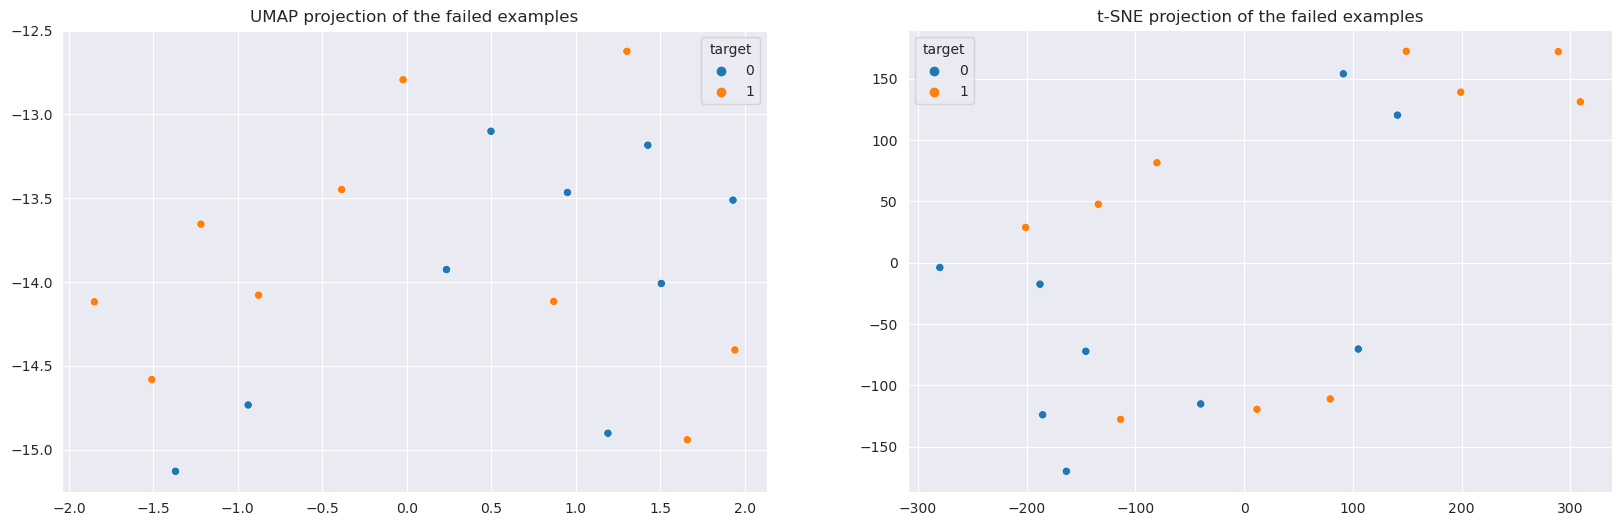

In [27]:
hue = y.iloc[all_bottleneck_cases]

umap_data = umap.UMAP(n_components=2, random_state=42).fit_transform(X.iloc[all_bottleneck_cases])
tsne_data = TSNE(n_components=2, perplexity= 5, init='pca', random_state=42).fit_transform(X.iloc[all_bottleneck_cases])

fig, axes = plt.subplots(1, 2, figsize=(20,6), squeeze=False)

sns.scatterplot(umap_data, x=umap_data[:, 0], y=umap_data[:, 1], hue=hue, ax=axes[0,0])
axes[0,0].set_title("UMAP projection of the failed examples")
sns.scatterplot(tsne_data, x=tsne_data[:, 0], y=tsne_data[:, 1], hue=hue, ax=axes[0,1])
axes[0,1].set_title("t-SNE projection of the failed examples")

plt.show()

Not much help.

### 6.3 Tabular evaluation of all the models
Will provide insights if generating an ensemble is a better option

In [28]:
from collections import defaultdict

def color_boolean(val):
    color =''
    if val == True:
        color = '#FFCCCB'
    elif val == False:
        color = '#90EE90'
    return 'background-color: %s' % color

analyze_dict = defaultdict(list)

for case in sorted(all_bottleneck_cases):
    for model, failed_cases in df_failed_cases.items():
        if case in failed_cases:
            analyze_dict[case].append(True)
        else:
            analyze_dict[case].append(False)
        
# pd.DataFrame(analyze_dict, index = list(df_failed_cases.keys())).style.applymap(color_boolean)
df_analyze = pd.DataFrame(analyze_dict, index = list(df_failed_cases.keys()))
correct_predictions = len(all_bottleneck_cases) - df_analyze.sum(axis = 1)  
ratio_of_correct_predictions = correct_predictions / len(all_bottleneck_cases)
df_analyze.insert(loc = 0, column= "correct_predictions", value=correct_predictions)
df_analyze.insert(loc = 1, column= "ratio_of_correct_predictions", value=ratio_of_correct_predictions)
df_analyze.style.applymap(color_boolean).background_gradient(subset = ["correct_predictions","ratio_of_correct_predictions"], cmap = "Oranges")


,correct_predictions,ratio_of_correct_predictions,9,15,55,72,73,77,84,94,104,140,155,184,271,275,290,355,373,399,402
LogisticRegression,6,0.315789,False,True,True,False,True,True,True,True,True,True,True,False,True,False,True,False,True,False,True
SVC,4,0.210526,True,True,True,True,True,True,True,True,False,True,True,True,True,False,True,False,True,False,True
DecisionTreeClassifier,6,0.315789,False,True,True,False,True,True,True,True,False,True,True,False,True,False,True,True,True,False,True
RandomForestClassifier,6,0.315789,False,True,True,False,True,True,True,True,False,True,True,False,True,True,True,True,False,False,True
XGBClassifier,6,0.315789,False,True,True,False,True,True,True,True,True,True,True,False,True,False,True,False,True,False,True
CatBoostClassifier,5,0.263158,False,True,True,False,True,True,True,True,True,True,True,False,True,False,True,True,True,False,True
LightGBM,5,0.263158,True,True,True,False,True,False,True,True,False,True,False,True,True,False,True,True,True,True,True


How to intrept: <br>
True indicates that test case index number 72 was predicted incorrectly by SVC but other models predicted it correctly. Whereas a false for test case 77 would mean, only LightGBM was correctly able to interpret it.

Yes, creating a ensemble model with soft voting will surely be an improve our AUC_ROC scores

# 7. Adding original data:

Our current performance can be upgraded if we leverage the original dataset and add more datapoints. The dataset contains 79 datapoints measuring the same features, except the id column.

Refer original dataset: https://www.kaggle.com/datasets/vuppalaadithyasairam/kidney-stone-prediction-based-on-urine-analysis

In [29]:
df_og = pd.read_csv("/kaggle/input/kidney-stone-prediction-based-on-urine-analysis/kindey stone urine analysis.csv")
df_og.head()

,gravity,ph,osmo,cond,urea,calc,target
0,1.021,4.91,725,14.0,443,2.45,0
1,1.017,5.74,577,20.0,296,4.49,0
2,1.008,7.20,321,14.9,101,2.36,0
3,1.011,5.51,408,12.6,224,2.15,0
4,1.005,6.52,187,7.5,91,1.16,0


### 7.1 Concat the two datasets

In [30]:
df_concat = pd.concat([df[columns], df_og[columns]])
df_concat
target_concat = pd.concat([df["target"], df_og["target"]])

print(df_concat.shape, target_concat.shape)

(493, 6) (493,)


### 7.2 Preprocess the concatenated datasets

In [31]:
X_concat = df_concat.copy(deep = True)
y_concat = target_concat.copy(deep = True)

X_train_concat, X_test_concat, y_train_concat, y_test_concat = train_test_split(X_concat, y_concat, test_size=0.15, random_state=42)


scaler = StandardScaler()
# poly = PolynomialFeatures()

X_train_concat = scaler.fit_transform(X_train_concat)
X_test_concat = scaler.transform(X_test_concat)
# X_test = poly.transform(X_test)

print(X_train_concat.shape, X_test_concat.shape)

(419, 6) (74, 6)


### 7.3 Train the models again

In [32]:
best_models_concat = {}

for model in models[1:]:
    print(model["name"])
    
    grid_search = RandomizedSearchCV(
        estimator = model["estimator"],
        param_distributions = model["hyperparameters"],
        scoring = "roc_auc",
        cv = 20, n_iter = 50, random_state = 42 
    )
    grid_search.fit(X_train_concat, y_train_concat)
    best_model = grid_search.best_estimator_
    
    y_pred = best_model.predict(X_test_concat)
    y_pred_proba = best_model.predict_proba(X_test_concat)[:, 1]
    
    acc_score = accuracy_score(y_test_concat,y_pred)
    conf_mat = confusion_matrix(y_test_concat,y_pred)
    roc_auc = roc_auc_score(y_test_concat, y_pred)
    roc_auc_predict_proba = roc_auc_score(y_test_concat, y_pred_proba)
    
    
    print(f'Best hyperparameters: {grid_search.best_params_}')
    print(f'Accuracy: {acc_score}')
    print(f'ROC AUC score: {roc_auc}')
    print(f'ROC AUC PROBA: {roc_auc_predict_proba}')
    print(conf_mat)
    print("==" * 25)

    best_models_concat[model['name']] = best_model

LogisticRegression
Best hyperparameters: {'C': 0.07158728631500196, 'max_iter': 892, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy: 0.7837837837837838
ROC AUC score: 0.7871396895787139
ROC AUC PROBA: 0.8237250554323725
[[31 10]
 [ 6 27]]
SVC
Best hyperparameters: {'C': 0.14528246637516026, 'kernel': 'rbf'}
Accuracy: 0.7702702702702703
ROC AUC score: 0.7660753880266076
ROC AUC PROBA: 0.8558758314855875
[[33  8]
 [ 9 24]]
DecisionTreeClassifier
Best hyperparameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 9, 'min_samples_split': 5}
Accuracy: 0.7162162162162162
ROC AUC score: 0.7232076866223207
ROC AUC PROBA: 0.8159645232815965
[[27 14]
 [ 7 26]]
RandomForestClassifier
Best hyperparameters: {'criterion': 'entropy', 'max_depth': 7, 'n_estimators': 245}
Accuracy: 0.7972972972972973
ROC AUC score: 0.7904656319290465
ROC AUC PROBA: 0.8529194382852919
[[35  6]
 [ 9 24]]
XGBClassifier
Best hyperparameters: {'booster': 'gbtree', 'eta': 0.04467752817973904, 'max_depth': 4,

In [33]:
best_models_concat

{'LogisticRegression': LogisticRegression(C=0.07158728631500196, max_iter=892, penalty='l1',
                    random_state=42, solver='liblinear'),
 'SVC': SVC(C=0.14528246637516026, probability=True),
 'DecisionTreeClassifier': DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=9,
                        min_samples_split=5, random_state=42),
 'RandomForestClassifier': RandomForestClassifier(criterion='entropy', max_depth=7, n_estimators=245,
                        random_state=42),
 'XGBClassifier': XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eta=0.04467752817973904,
               eval_metric='auc', feature_types=None, gamma=None, gpu_id=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=

### 7.4 Error Analysis:

In [34]:
df_failed_cases_concat = {}
all_bottleneck_cases_concat = set()
for model,estimator in best_models_concat.items():
    failed_cases = test_case_failed(estimator)
    df_failed_cases_concat[model] = failed_cases
    all_bottleneck_cases_concat = all_bottleneck_cases_concat.union(set(failed_cases))  

all_bottleneck_cases_concat = list(all_bottleneck_cases_concat)    
print("y_true:", y.iloc[all_bottleneck_cases_concat].to_list())
print("All bottleneck cases:", all_bottleneck_cases_concat)
print("Total bottleneck examples:", len(all_bottleneck_cases_concat))

y_true: [1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1]
All bottleneck cases: [262, 72, 9, 73, 140, 141, 77, 15, 271, 402, 275, 84, 25, 155, 94, 290, 355, 39, 104, 175, 373, 118, 55, 184]
Total bottleneck examples: 24


In [35]:
analyze_dict = defaultdict(list)

for case in sorted(all_bottleneck_cases_concat):
    for model, failed_cases in df_failed_cases_concat.items():
        if case in failed_cases:
            analyze_dict[case].append(True)
        else:
            analyze_dict[case].append(False)
        
df_analyze_concat = pd.DataFrame(analyze_dict, index = list(df_failed_cases_concat.keys()))
correct_predictions = len(all_bottleneck_cases_concat) - df_analyze_concat.sum(axis = 1)  
ratio_of_correct_predictions = correct_predictions / len(all_bottleneck_cases_concat)
df_analyze_concat.insert(loc = 0, column= "correct_predictions", value=correct_predictions)
df_analyze_concat.insert(loc = 1, column= "ratio_of_correct_predictions", value=ratio_of_correct_predictions)
df_analyze_concat.style.applymap(color_boolean).background_gradient(subset = ["correct_predictions","ratio_of_correct_predictions"], cmap = "Greens")



,correct_predictions,ratio_of_correct_predictions,9,15,25,39,55,72,73,77,84,94,104,118,140,141,155,175,184,262,271,275,290,355,373,402
LogisticRegression,11,0.458333,False,True,False,False,True,False,True,True,True,True,False,False,True,False,True,False,False,False,True,False,True,True,True,True
SVC,10,0.416667,True,True,False,False,True,False,True,True,True,True,False,False,True,False,True,False,True,False,True,False,True,False,True,True
DecisionTreeClassifier,7,0.291667,True,False,True,True,True,False,True,True,True,True,False,True,True,True,True,True,False,False,False,True,True,True,True,False
RandomForestClassifier,15,0.625000,False,True,False,False,True,False,True,True,True,False,False,False,True,False,True,False,False,False,True,False,True,False,False,False
XGBClassifier,13,0.541667,False,True,False,False,True,False,True,True,True,True,True,False,False,False,True,False,False,False,True,True,True,False,False,False
CatBoostClassifier,13,0.541667,False,True,False,False,True,True,True,True,True,False,True,False,True,False,True,False,False,False,False,True,True,False,False,False
LightGBM,10,0.416667,False,True,False,False,True,False,True,True,True,False,True,True,True,False,True,False,False,True,True,True,True,False,True,False


### 7.5 Improvment of adding original data

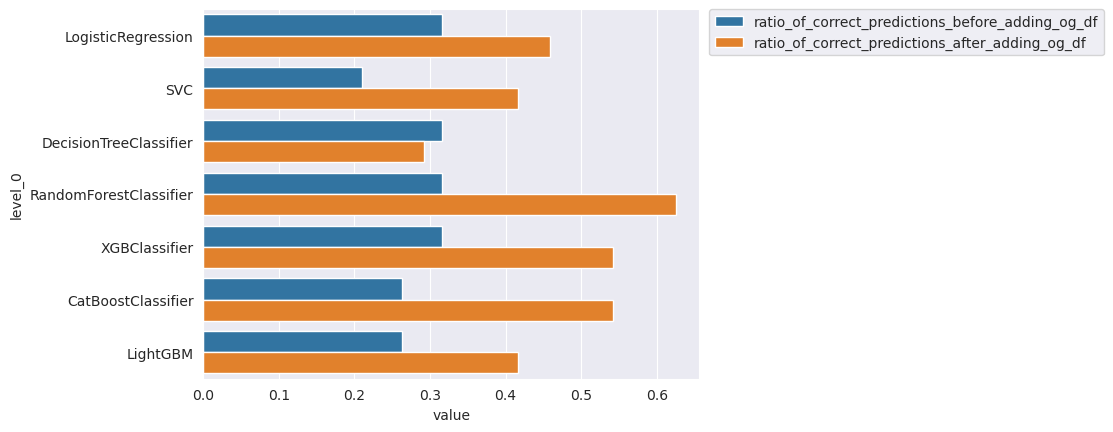

In [36]:
improv_df = pd.merge(df_analyze["ratio_of_correct_predictions"], df_analyze_concat["ratio_of_correct_predictions"], 
                     left_index=True, right_index=True, suffixes=("_before_adding_og_df", "_after_adding_og_df"))
improv_df.set_index(improv_df.index, inplace=True)
improv_df = improv_df.stack().to_frame('value').reset_index()
improv_df.rename(columns={'level_1':'Item'},inplace=True)
improv_df

sns.barplot(data=improv_df, y='level_0', x='value', hue='Item')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

#### Insight:
1. By adding more data we have improved the ratio of correct predictions per model.
2. We can leverage the ratio of correctness to create ensemble with weighted models

# 8. Creating ensemble

### 8.1 Model weight using softmax function

In [37]:
def softmax(x):
    return(np.exp(x)/np.exp(x).sum())

model_weights = softmax(df_analyze_concat["ratio_of_correct_predictions"].values)
model_weights

array([0.14044886, 0.13471707, 0.1188874 , 0.16592073, 0.15265444,
       0.15265444, 0.13471707])

### 8.2 Train Voting Classifier

In [38]:
final_estimators = [(model_name,model) for model_name, model in best_models_concat.items()]

ens_model = VotingClassifier(estimators=final_estimators, voting='soft')
ens_model = ens_model.fit(X_train_concat, y_train_concat)

y_pred = ens_model.predict(X_test_concat)
y_pred_proba = ens_model.predict_proba(X_test_concat)[:, 1]

acc_score = accuracy_score(y_test_concat,y_pred)
conf_mat = confusion_matrix(y_test_concat,y_pred)
roc_auc = roc_auc_score(y_test_concat, y_pred)
roc_auc_predict_proba = roc_auc_score(y_test_concat, y_pred_proba)


print(f'Accuracy: {acc_score}')
print(f'ROC AUC score: {roc_auc}')
print(f'ROC AUC PROBA: {roc_auc_predict_proba}')
print(conf_mat)
print("==" * 25)

Accuracy: 0.8108108108108109
ROC AUC score: 0.8085735402808573
ROC AUC PROBA: 0.8470066518847007
[[34  7]
 [ 7 26]]


### 8.3 Compare ensemble model with best performing model using K-foldCV

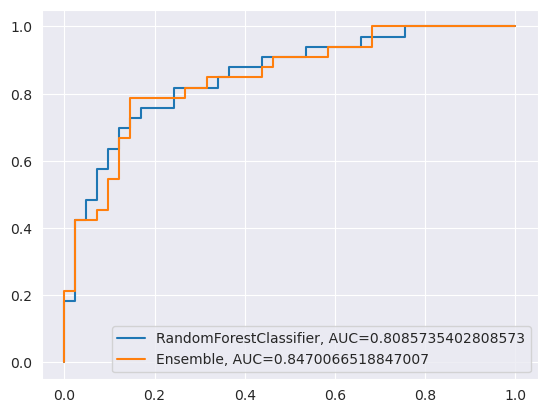

In [39]:
y_pred_rf = best_models_concat["RandomForestClassifier"].predict_proba(X_test_concat)[:, 1]
auc_rf = roc_auc_score(y_test_concat, y_pred)
fpr, tpr, _ = roc_curve(y_test_concat, y_pred_rf)
plt.plot(fpr,tpr,label="RandomForestClassifier, AUC="+str(auc_rf))

y_pred_ens = ens_model.predict_proba(X_test_concat)[:, 1]
fpr, tpr, _ = roc_curve(y_test_concat, y_pred_ens)
auc_ens = roc_auc_score(y_test_concat, y_pred_ens)


plt.plot(fpr,tpr,label="Ensemble, AUC="+str(auc_ens))
plt.legend()

### Ensemble worked out for the best!

# 9. Submit Test data predictions

In [40]:
test_df = pd.read_csv("../input/playground-series-s3e12/test.csv")
print(test_df.shape)
test_df = test_df[columns]
test_df = scaler.transform(test_df)
test_pred_proba = ens_model.predict_proba(test_df)[:,1]
test_pred = ens_model.predict(test_df)

(276, 7)


In [41]:
np.unique(test_pred, return_counts=True)
print(156/276, 120/276)

print(target_concat.value_counts(normalize = True))

0.5652173913043478 0.43478260869565216
0    0.557809
1    0.442191
Name: target, dtype: float64


Distribution seems 

In [42]:
sub_df["target"] = test_pred_proba
sub_df.to_csv('submission.csv', index=False)

sub_df.shape

(276, 2)

## Please upvote if you liked the work :)